# Organización de Datos (75.06/95.58)
## Primer Cuatrimestre 2021
### Trabajo Práctico N°1
#### Curso 1: Argerich

----

##### Introducción:
En el año 2015 Nepal fue afectado por el terremoto Gorkha, un sismo que registró una
magnitud de 7.8 en la escala Richter y tuvo su epicentro en la ciudad de Kathmandu.
Aproximadamente 600,000 estructuras en el centro y pueblos aledaños fueron dañadas o
destruidas. Un análisis posterior al sismo llevado por la Comisión Nacional de
Planeamiento de Nepal comunicó que la pérdida total económica ocasionada por el
terremoto fue de aproximadamente $7 mil millones (USD; NPC, 2015).
El dataset para el presente TP está compuesto de encuestas realizadas por Kathmandu
Living Labs y el Central Bureau of Statistics y contiene información sobre el impacto del
terremoto, estado de viviendas y estadísticas sociodemográficas.
Particularmente el dataset se enfoca en cómo eran las condiciones de una determinada vivienda y cuál fue su grado de daño luego del accidente. 

##### Objetivo:
El TP consiste en realizar un análisis exploratorio de los datos provistos con el objetivo de
determinar características y variables importantes, descubrir insights interesantes, y
analizar la estructura de los mismos.

# Análisis exploratorio de los datos
#### Empecemos importando los recursos necesarios

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib as mpl
import cycler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split

#seteando la paleta de colores
estilo = "mako"
cmap_cycler = sns.color_palette(estilo, n_colors = 280)
cmap = sns.color_palette(estilo, n_colors = 2000)[:500:-1]


plt.rcParams['axes.grid'] = True
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_cycler[200::-20])
cmap_horizontal = mpl.rcParams['axes.prop_cycle'][::5]

In [2]:
# lectura de archivos csv
train_values=pd.read_csv('train_values.csv',
                        dtype={
                            'geo_level_1_id':'int8',
                            'geo_level_2_id':'int16',
                            'geo_level_3_id':'int16',
                            'count_floors_pre_eq':'int8',
                            'age':'int16',
                            'area_percentage':'int8',
                            'height_percentage':'int8',
                            'land_surface_condition':'category',                 
                            'foundation_type':'category',                          
                            'roof_type':'category',                                 
                            'ground_floor_type':'category',                        
                            'other_floor_type':'category',                          
                            'position':'category',                                  
                            'plan_configuration':'category',
                            'has_superstructure_adobe_mud':'bool',               
                            'has_superstructure_mud_mortar_stone':'bool',        
                            'has_superstructure_stone_flag':'bool',             
                            'has_superstructure_cement_mortar_stone':'bool',     
                            'has_superstructure_mud_mortar_brick':'bool',        
                            'has_superstructure_cement_mortar_brick':'bool',     
                            'has_superstructure_timber':'bool',                  
                            'has_superstructure_bamboo':'bool',                  
                            'has_superstructure_rc_non_engineered':'bool',       
                            'has_superstructure_rc_engineered':'bool',          
                            'has_superstructure_other':'bool',
                            'legal_ownership_status':'category',
                            'count_families':'int8',
                            'has_secondary_use':'bool',                          
                            'has_secondary_use_agriculture':'bool',             
                            'has_secondary_use_hotel':'bool',                    
                            'has_secondary_use_rental':'bool',                  
                            'has_secondary_use_institution':'bool',             
                            'has_secondary_use_school':'bool',                
                            'has_secondary_use_industry':'bool',              
                            'has_secondary_use_health_post':'bool',         
                            'has_secondary_use_gov_office':'bool',           
                            'has_secondary_use_use_police':'bool',             
                            'has_secondary_use_other':'bool'                   
                        })
train_labels=pd.read_csv('train_labels.csv',
                        dtype={
                            'building_id':'int64',
                            'damage_grade':'int8'
                        })

### Limpieza de datos
- ¿Hay datos faltantes?
    - ¿Son muchos? Caso contrario podríamos simplemente filtrarlos.
- ¿Todos los datos están con el formato correcto?
    - ¿Es necesario transformar alguna columna a tipo categórico/numérico/date_time?
- ¿Los dataframes son muy grandes?
    - ¿Es necesario algun trabajo previo para minimizar el espacio en memoria?
- ¿Hay datos que no tengan sentido?
    - Cuyos valores sean muy grandes para el contexto
    - Que no sean posibles

#### Reviso valores null en mis dataframes

In [3]:
train_labels.isnull().any()

building_id     False
damage_grade    False
dtype: bool

In [4]:
train_values.isnull().any()

building_id                               False
geo_level_1_id                            False
geo_level_2_id                            False
geo_level_3_id                            False
count_floors_pre_eq                       False
age                                       False
area_percentage                           False
height_percentage                         False
land_surface_condition                    False
foundation_type                           False
roof_type                                 False
ground_floor_type                         False
other_floor_type                          False
position                                  False
plan_configuration                        False
has_superstructure_adobe_mud              False
has_superstructure_mud_mortar_stone       False
has_superstructure_stone_flag             False
has_superstructure_cement_mortar_stone    False
has_superstructure_mud_mortar_brick       False
has_superstructure_cement_mortar_brick  

Podemos ver que, por suerte, **ninguno de los dataframes contienen valores NaN.**  
Esto quiere decir que no será necesario ningún tipo de filtro en los datasets a causa de valores faltantes.

#### Chequeando formato de los datos

damage_grade originalmente era int64

In [5]:
train_labels.dtypes

building_id     int64
damage_grade     int8
dtype: object

Muchos valores categóricos eran objects y muchos valores booleanos eran int64, cambiamos sus tipos para optimizar.

In [6]:
train_values.dtypes

building_id                                  int64
geo_level_1_id                                int8
geo_level_2_id                               int16
geo_level_3_id                               int16
count_floors_pre_eq                           int8
age                                          int16
area_percentage                               int8
height_percentage                             int8
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                  bool
has_superstructure_mud_mortar_stone           bool
has_superstructure_stone_flag                 bool
has_superstructure_cement_mortar_stone        bool
has_superstructure_mud_mortar_b

#### Manejo de memoria del dataset
El valor inicialmente (sin castear las columnas al leer el csv) era de 3.97 Mb. Ahora se ve que decreció.

In [7]:
(train_labels.memory_usage()/(2**20)).sum()

2.2368783950805664

El valor inicialmente era de 77.54 Mb podemos observar que ahora la memoria se usa de forma mucho mas óptima.

In [8]:
(train_values.memory_usage()/(2**20)).sum()

12.179516792297363

#### Buscando datos fuera de lo común  
Buscamos si hay valores que no tengan sentido.

##### ¿Hay algún building_id en un dataset que **no** esté en el otro?
Los comparamos y chequeamos si hay algún false, los sumamos.

In [9]:
(train_values['building_id'] != train_labels['building_id']).sum()

0

Observamos que hay correspondencia 1 a 1 entre ambos datasets.
Eso significa que se puede hacer un merge (lo haremos mas adelante)

##### ¿Las variables geo_level_id tiene los valores que dice el enunciado?

In [10]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].max()

geo_level_1_id       30
geo_level_2_id     1427
geo_level_3_id    12567
dtype: int16

Vemos que se corresponde con el enunciado.

In [11]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].min()

geo_level_1_id    0
geo_level_2_id    0
geo_level_3_id    0
dtype: int16

Se corresponde con el enunciado.

##### ¿Hay algún valor de cantidad de familias por hogar que nos llame la atención?
No nos llama la atencion que existan algunas edificaciones con mas de 7 familias, podrían ser por ejemplo bloques de departamentos.
Tambien observamos que hay 20 mil edificaciones sin familias, esto puede ser tranquilamente por ser edificaciones destinadas a otras actividades.

In [12]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

##### ¿Hay valores raros en la cantidad de pisos por edificio?
No vemos que sea inverosimil que un solo edificio tenga 9 u 8 pisos.

In [13]:
train_values['count_floors_pre_eq'].value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count_floors_pre_eq, dtype: int64

##### ¿Area_percentage y Height_percentage están dentro de los valores [0,100]?
Como se observa a continuación, sí.

In [14]:
train_values[['area_percentage','height_percentage']].max()

area_percentage      100
height_percentage     32
dtype: int8

In [15]:
train_values[['area_percentage','height_percentage']].min()

area_percentage      1
height_percentage    2
dtype: int8

##### ¿Hay valores fuera de lo normal para la edad de las edificaciones?

In [16]:
train_values['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
130        9
140        9
180        7
170        6
160        6
175        5
135        5
190        3
145        3
195        2
165        2
185        1
155        1
Name: age, dtype: int64

Si bien podemos observar que hay muchos edificios con antigüedades entre 0 y 200 años (lo cual
consideramos normal) podemos ver que **hay 1390 con antigüedades** de 995 años.  
Lo que nos llama la atención de esto es la brecha entre el valor 200 y 995.
- ¿Por qué no hay valores intermedios? 
- ¿Es posible que una edificación sea tan vieja?  

La forma en la que decidimos interpretar estos datos es que no se tiene una fecha concreta de la construcción de estas viviendas, pero que al ser tan antiguas (más de 200 años) se decidió ingresarlas con edades de 995 años (por eso tantas tienen exactamente esa edad).  
Para el resto de nuestro análisis consideraremos a esas viviendas como simplemente *viviendas muy viejas*

In [17]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,False,False,False,False,False,False,False,False,False,False
1,28830,8,900,2812,2,10,8,7,o,r,...,False,False,False,False,False,False,False,False,False,False
2,94947,21,363,8973,2,10,5,5,t,r,...,False,False,False,False,False,False,False,False,False,False
3,590882,22,418,10694,2,10,6,5,t,r,...,False,False,False,False,False,False,False,False,False,False
4,201944,11,131,1488,3,30,8,9,t,r,...,False,False,False,False,False,False,False,False,False,False


In [18]:
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


#### Mergeamos los dos dataframes ya que tiene una correspondencia 1 a 1

In [19]:
df=train_values.merge(train_labels)
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,False,False,False,False,False,False,False,False,False,3
1,28830,8,900,2812,2,10,8,7,o,r,...,False,False,False,False,False,False,False,False,False,2
2,94947,21,363,8973,2,10,5,5,t,r,...,False,False,False,False,False,False,False,False,False,3
3,590882,22,418,10694,2,10,6,5,t,r,...,False,False,False,False,False,False,False,False,False,2
4,201944,11,131,1488,3,30,8,9,t,r,...,False,False,False,False,False,False,False,False,False,3


# Análisis por región geográfica

Tenemos 3 grados de daño posibles. Primero analizamos cuantas edificaciones fueron afectadas para cada uno de estos grados de daño sin discriminar por región geográfica.

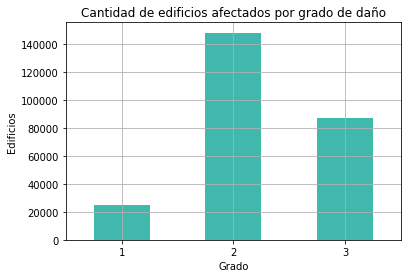

In [20]:
general_damage = df['damage_grade'].value_counts(sort=False)
general_damage_normalize = df['damage_grade'].value_counts(sort=False, normalize=True)
general_damage.plot(kind='bar', rot=0)
plt.xlabel('Grado')
plt.ylabel('Edificios')
plt.title('Cantidad de edificios afectados por grado de daño')
plt.show()

Podemos ver en el gráfico anterior que la gran mayoría de edificios tienen daño medio.
Queremos ver que fue lo que ocasionó ese nivel de daño, así que vamos a empezar a discriminar por distribución geográfica y analizar las variables de cada dato.


En el siguiente gráfico vemos que las edificaciones no están distribuidas uniformemente en las regiones indicadas en *geo_level_1_id*.

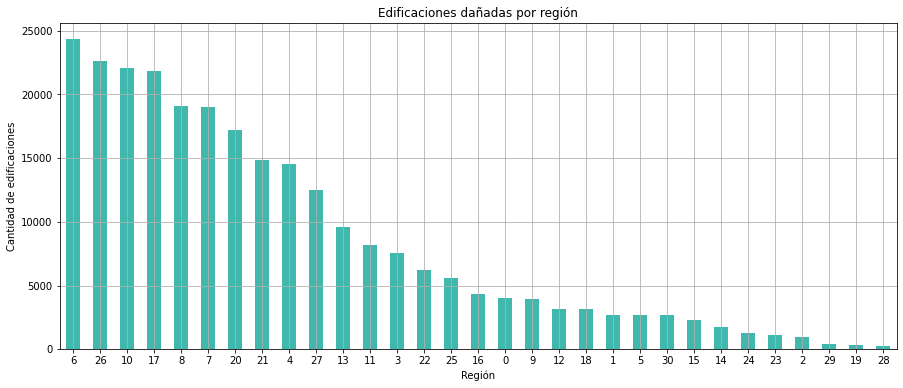

In [21]:
df['geo_level_1_id'].value_counts().plot(kind='bar', figsize=(15,6), rot=0, title='Edificaciones dañadas por región')
ax=plt.gca()
ax.set_ylabel('Cantidad de edificaciones')
ax.set_xlabel('Región')
plt.show()

De acá se puede ver que la zona que más aparece en el dataset es la zona 6.  
Pero esto no nos dice el grado de daño de la zona 6. Es decir, podría haber muchos edificios en la zona
6 con daño de tipo 1 (poco daño)  

## Discriminemos por **grado de daño.**

In [22]:
damage_grade_por_region_geoLeve1=df[['geo_level_1_id','damage_grade']].value_counts().to_frame().reset_index().rename(columns={0:'count'}).pivot_table(index='geo_level_1_id',columns='damage_grade',values='count').fillna(0)
damage_grade_por_region_geoLeve1

damage_grade,1,2,3
geo_level_1_id,,,
0,337.0,3075.0,599.0
1,411.0,1985.0,305.0
2,85.0,610.0,236.0
3,245.0,4550.0,2745.0
4,521.0,11164.0,2883.0
5,446.0,2014.0,230.0
6,2108.0,16222.0,6051.0
7,1033.0,11273.0,6688.0
8,654.0,8513.0,9913.0


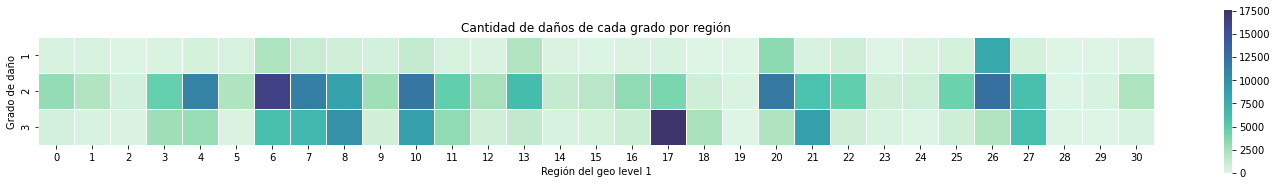

In [23]:
plt.figure(figsize=(25,3))
sns.heatmap(data=damage_grade_por_region_geoLeve1.T,cmap=cmap, linewidths=1, square=True)
plt.title('Cantidad de daños de cada grado por región')
plt.ylabel('Grado de daño')
plt.xlabel('Región del geo level 1')
plt.show()

En el heatmap podemos observar que agrupando las edificaciones según *geo_level1* la región con mayor daño de grado 3 es la región 17 (por mucho) y la región 6 tuvo mucho daño de grado medio.  

Este daño: 
- ¿Se dá porque hay más edificios en la zona 17? 
- ¿Porcentualmente hay muchos edificios dañados con grado 3 en esa zona?  

En caso de que la segunda pregunta sea verdadera, podemos concluir que sería una buena idea ver **qué caracteristicas diferencian** a las edificaciones de la región 17 y la región 6.  

- ¿Hay diferencias en las estructuras?
    - ¿Cantidad de pisos?
    - ¿Cantidad de familias viviendo ahi?
    - ¿Qué dicen los datos binarios de las super_estructuras?
- ¿Vale la pena usar el dato de geo_level_2 y geo_level_3?
    - Deberíamos identificar que zonas de geo_level_2 y geo_level_3 están dentro de geo_level_1, si es que quisieramos usar ese dato

### Escribamos el valor de daño grado 3 con respecto al total de daños en esa zona

In [24]:
daños_totales=damage_grade_por_region_geoLeve1[1]+damage_grade_por_region_geoLeve1[2]+damage_grade_por_region_geoLeve1[3]
daños_porcentuales_geoLevel1=damage_grade_por_region_geoLeve1.agg(lambda x: x/daños_totales)
daños_porcentuales_geoLevel1

damage_grade,1,2,3
geo_level_1_id,,,
0,0.084019,0.766642,0.149339
1,0.152166,0.734913,0.112921
2,0.091300,0.655209,0.253491
3,0.032493,0.603448,0.364058
4,0.035763,0.766337,0.197900
5,0.165799,0.748699,0.085502
6,0.086461,0.665354,0.248185
7,0.054386,0.593503,0.352111
8,0.034277,0.446174,0.519549


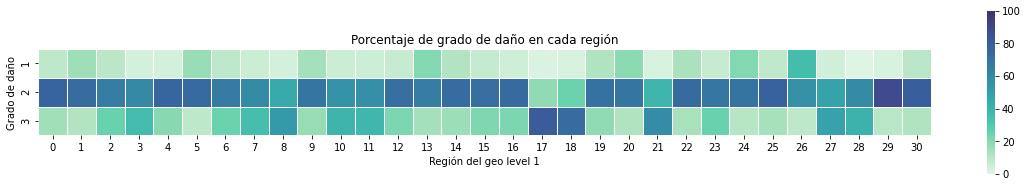

In [25]:
plt.figure(figsize=(20,3))
sns.heatmap(data=daños_porcentuales_geoLevel1.T*100,cmap=cmap,vmin=0,vmax=100, linewidths=1, square=True)
plt.title('Porcentaje de grado de daño en cada región')
plt.ylabel('Grado de daño')
plt.xlabel('Región del geo level 1')
plt.show()

El contraste entre este heatmap y el anterior es enorme.  
Primero que nada podemos observar que la mayor proporción se sitúa en los daños de grado 2. Esto no es para nada raro si consideramos que, como muestra el primer grafico del notebook, la mayoría de los edificios mostraron daños de grado 2.  
Las excepciones son las zonas 17 y 18 que mostraron porcentualmente un gran daño de grado 3.  
Podemos ver que la zona 29 tiene la mayor proporción de daños de grado 2 pero en el heatmap anterior **está practicamente vacío.**  
Esto lo podemos atribuir a que al haber tan pocos datos sobre los daños en esa zona, porcentualmente da valores muy grandes.  
Es por eso que para eliminar estas conclusiones que pueden ser erróneas, filtraremos los datos de las zonas que estén por debajo de cierto valor.  
Otra cosa importante a observar es que las zonas 17 y 18 son una excepción a la regla, y muestran porcentualmente mayor cantidad de daños de grado 3. Es decir que efectivamente **fueron las zonas mas dañadas por este terremoto**. Pero no nos detenemos ahi, podemos ver que la zona 18 tiene una proporción de daño 3 similar a la zona 17, pero en el siguiente gráfico veremos que la cantidad de daños de tipo 3 en la zona 18 son mucho menores a la zona 17, es decir **hubo más edificios dañados en la zona 17.**

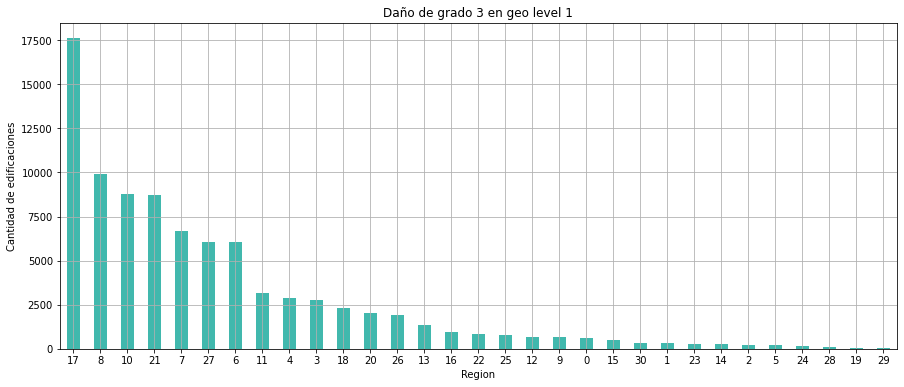

In [26]:
geo_level_1_damage_3=df.loc[df['damage_grade'] == 3, 'geo_level_1_id'].value_counts()
geo_level_1_damage_3.plot(kind='bar', figsize=(15,6), rot=0, title='Daño de grado 3 en geo level 1')
ax=plt.gca()
ax.set_ylabel('Cantidad de edificaciones')
ax.set_xlabel('Region')
plt.show()

El mayor daño se concentra en las regiones 17, 8, 10, 21, 7, 27, 6.
- ¿A qué se debe esto? ¿Son zonas con edificaciones más antiguas? 
- ¿Los materiales de construcción son distintos a los de las zonas que se vieron menos afectadas?  

Las zonas con mucho menos daños pueden ser por haber menor cantidad de edificios, es probable que tengamos que filtrar esos datos porque son ruido en nuestro análisis.  
Como mencionamos anteriormente, en la zona 18 hay muy pocos daños si bien porcentualmente son muchos. Esto nos da la idea de que no hay muchos edificios en esa zona. Para hacer un análisis bueno deberíamos ver las zonas con mayor cantidad de edificios dañados.

Vamos a filtrar nuestro dataset. Calculamos el total de edificios dañados por region y calculamos el cuantil 25%. Nos quedamos con los valores que superen eso (de esa forma eliminamos valores muy chicos).

### Así quedan los gráficos cuando eliminamos los datos con poca relevancia

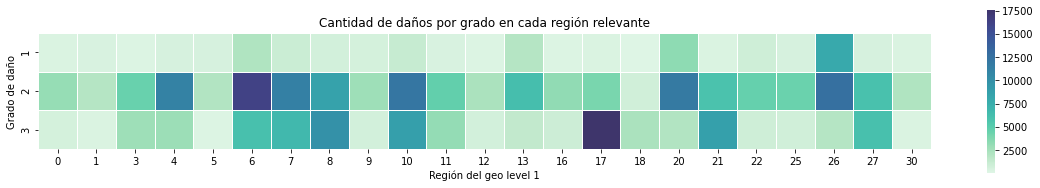

In [27]:
damage_grade_relevante_por_region=damage_grade_por_region_geoLeve1[daños_totales>daños_totales.quantile(0.25)]
plt.figure(figsize=(20,3))
sns.heatmap(data=damage_grade_relevante_por_region.T,cmap=cmap, linewidths=1, square=True)
plt.title('Cantidad de daños por grado en cada región relevante')
plt.ylabel('Grado de daño')
plt.xlabel('Región del geo level 1')
plt.show()

<a id='another_cell'></a>

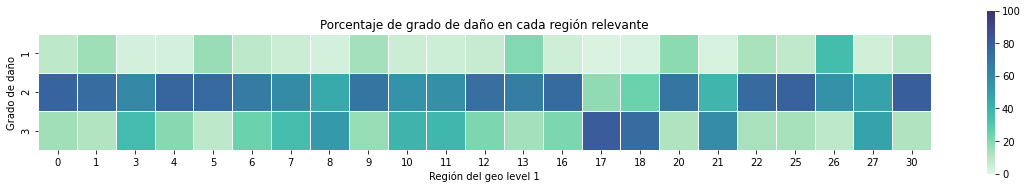

In [28]:
daños_totales_relevantes=daños_totales[daños_totales>daños_totales.quantile(0.25)]
daños_porcentuales_relevantes_geoLevel1=damage_grade_relevante_por_region.agg(lambda x: x/daños_totales_relevantes)
plt.figure(figsize=(20,3))
sns.heatmap(data=daños_porcentuales_relevantes_geoLevel1.T*100,cmap=cmap,vmin=0,vmax=100, linewidths=1, square=True)
plt.title('Porcentaje de grado de daño en cada región relevante')
plt.ylabel('Grado de daño')
plt.xlabel('Región del geo level 1')
plt.show()

Cosas que llaman la atención es que proporcionalmente la mayoria de daños son de grado 2, con muy pocas excepciones.  
Grafiquemos la cantidad de daños que hubo de distinto grado de daño, en las zonas que consideramos relevantes. 

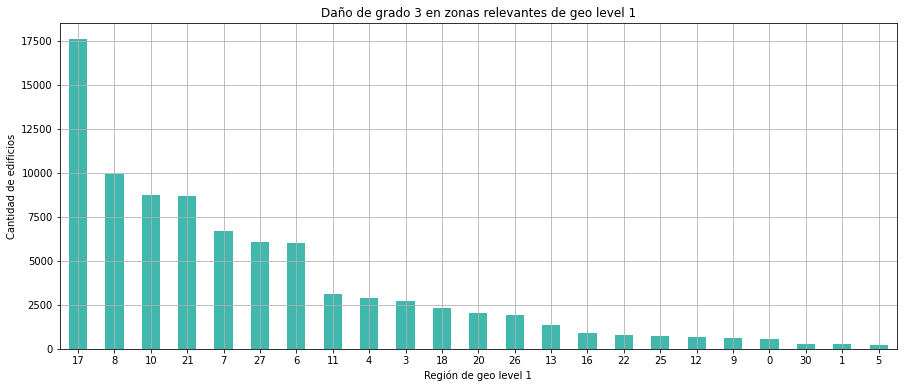

In [29]:
daño_grado3_geo1_relevantes=damage_grade_por_region_geoLeve1[daños_totales>daños_totales.quantile(0.25)][3]
daño_grado3_geo1_relevantes=daño_grado3_geo1_relevantes.sort_values(ascending=False)
daño_grado3_geo1_relevantes.plot(kind='bar',figsize=(15,6), rot=0, title='Daño de grado 3 en zonas relevantes de geo level 1')
plt.ylabel('Cantidad de edificios')
plt.xlabel('Región de geo level 1')
plt.show()

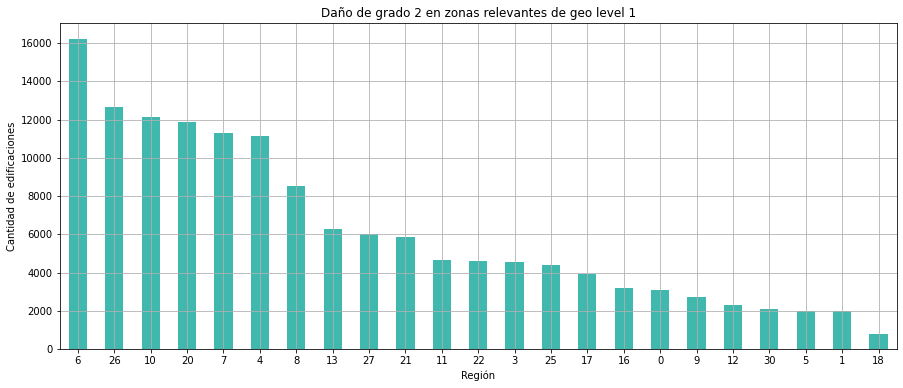

In [30]:
geo_level_1_damage_2=df.loc[df['damage_grade'] == 2, 'geo_level_1_id'].value_counts()
geo_level_1_damage_2=geo_level_1_damage_2.sort_index()[daños_totales>daños_totales.quantile(0.25)].sort_values(ascending=False)
geo_level_1_damage_2.plot(kind='bar', figsize=(15,6), rot=0, title='Daño de grado 2 en zonas relevantes de geo level 1')
ax=plt.gca()
ax.set_ylabel('Cantidad de edificaciones')
ax.set_xlabel('Región')
plt.show()

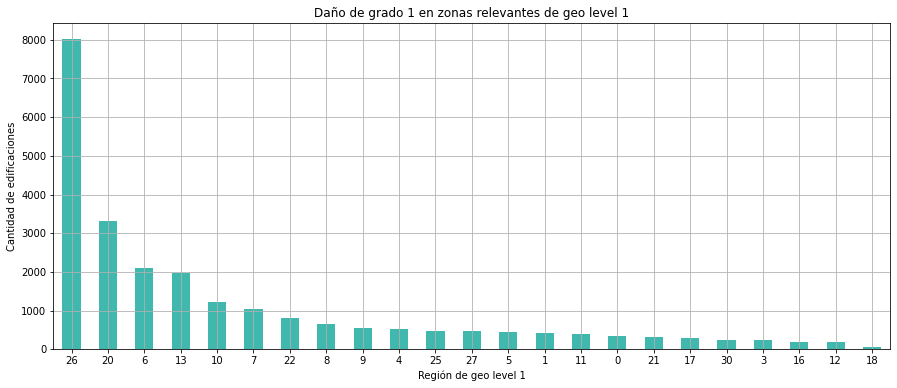

In [31]:
geo_level_1_damage_1=df.loc[df['damage_grade'] == 1, 'geo_level_1_id'].value_counts()
geo_level_1_damage_1=geo_level_1_damage_1.sort_index()[daños_totales>daños_totales.quantile(0.25)].sort_values(ascending=False)
geo_level_1_damage_1.plot(kind='bar', figsize=(15,6), rot=0, title='Daño de grado 1 en zonas relevantes de geo level 1')
ax=plt.gca()
ax.set_ylabel('Cantidad de edificaciones')
ax.set_xlabel('Región de geo level 1')
plt.show()

#### Podemos apreciar la gran concentración de daño en unas pocas zonas, incluso quedándonos con los 3 cuartiles superiores, se nota que el las zonas más afectadas siguen destacando.  
En particular vemos lo que ya habíamos observado con anterioridad:
- La zona 26 es la que sufrió mayor cantidad de daños leves
- La zona 17 es la que sufrió la mayor cantidad de daños graves
- La zona 6 es la que sufrió mayor cantidad de daños medios
    - Vale aclarar que se nota la diferencia entra la cantidad de zonas con daños medios por sobre los otros tipos de daños  
    
Debemos ver **qué características las diferencian de las otras zonas** y asi podremos hacer conclusiones.

#### ¿Es correcto tomar a la región 17 de *geo_level_1* como un conjunto o deberíamos distinguir por sus subregiones?

La región 17 de *geo_level_1* tiene 79 subregiones según *geo_level_2*. Si estas subregiones se comportan de forma similar podemos hacer el análisis sobre la región 17, en cambio, si las subregiones muestran características dispares tendriamos que agruparlas de otra manera.

In [32]:
len(df.loc[df['geo_level_1_id']==17, 'geo_level_2_id'].unique())

79

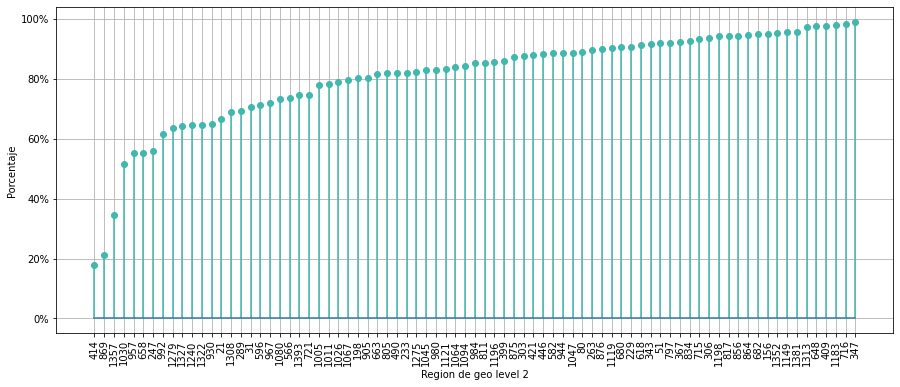

In [33]:
geo_level_2 = df.loc[df['geo_level_1_id']==17,['geo_level_2_id','damage_grade']]
geo_level_2['damage_grade_3'] = geo_level_2['damage_grade'] == 3
dataframe_a_plotear = geo_level_2[['geo_level_2_id','damage_grade_3']].groupby('geo_level_2_id').agg(lambda x: x.sum()/x.count()).sort_values('damage_grade_3')
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.stem(dataframe_a_plotear.index.astype(str),dataframe_a_plotear['damage_grade_3'])
plt.ylabel('Porcentaje')
plt.xlabel('Region de geo level 2')
plt.xticks(rotation=90)
plt.show()


Vemos que la mayoría de las subregiones tienen una proporción de daños graves muy altas. Por lo tanto tomamos a la región 17 como un conjunto de regiones *geo_level_2* que tienen caracteristicas similares y pueden analizarse en conjunto.

## Análisis según las condiciones y los materiales de construcción

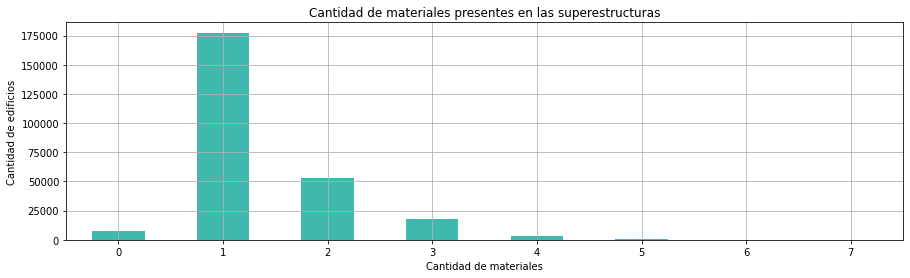

In [34]:
superstructure_columns = ['has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']
superstructure_raw = df.loc[:,superstructure_columns + ['damage_grade']]
superstructure_raw['sum'] = superstructure_raw.iloc[:,:-1].sum(axis=1)
superstructure_raw['sum'].value_counts(sort=False, normalize=False).plot(kind='bar', figsize=(15,4), rot=0)
plt.xlabel('Cantidad de materiales')
plt.ylabel('Cantidad de edificios')
plt.title('Cantidad de materiales presentes en las superestructuras')
plt.show()

La mayoría de las edificaciones cuentan con una superestructura hecha con un único tipo de materiales de construcción. También, en menor medida, hay algunas que no tienen ninguna superestructura asignada en el DataFrame (¿Es posible esto? ¿No deberían al menos tener *has_superstructure_other*?) y algunas que cuentan con hasta 7 superestructuras distintas.

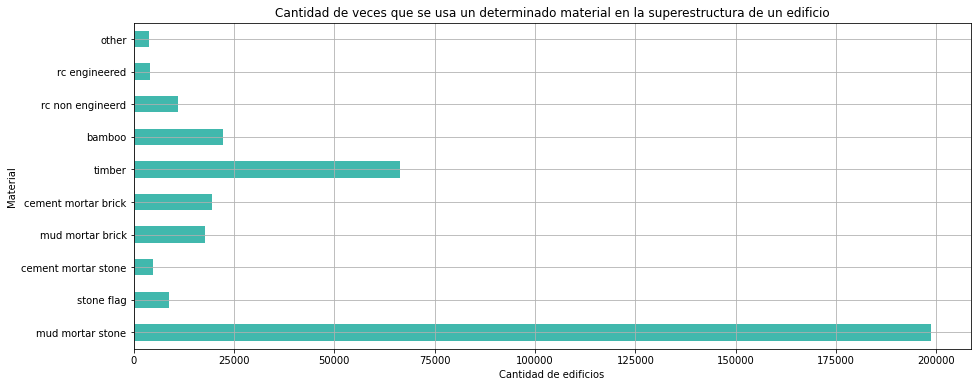

In [35]:
superstructure_raw.sum().iloc[:-2].plot(kind='barh', figsize=(15,6))

plt.title('Cantidad de veces que se usa un determinado material en la superestructura de un edificio')
plt.ylabel('Material')
plt.xlabel('Cantidad de edificios')
plt.yticks([0,1,2,3,4,5,6,7,8,9],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()


El material más usado para la construccion de edificaciones es **barro - piedra**, y en segundo lugar **Timber**. Más adelante analizamos en particular cúal fue la respuesta de estos materiales ya que, al ser usado en la mayoría de las edificaciones, nos pueden dar una idea de que tan relevantes fueron los materiales de construcción a la hora de reducir o no el impacto del terremoto.

El gráfico a continuación muesta la distribución de materiales sin tener el cuenta a **barro - piedra**.

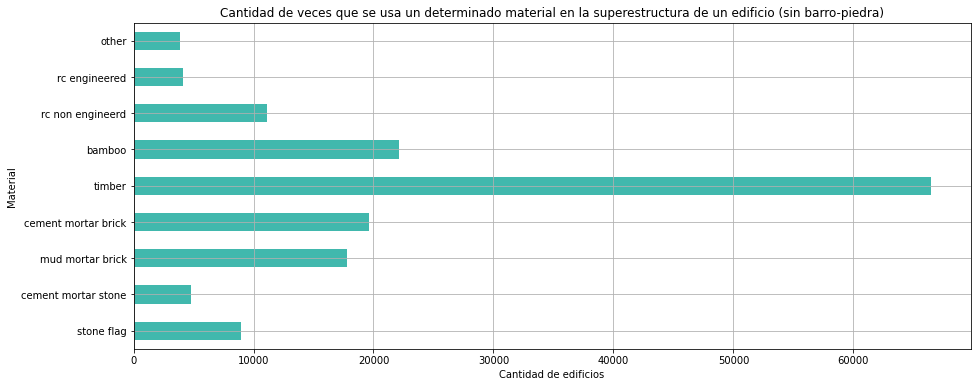

In [36]:
superstructure_raw.sum().iloc[1:-2].plot(kind='barh', figsize=(15,6))
plt.title('Cantidad de veces que se usa un determinado material en la superestructura de un edificio (sin barro-piedra)')
plt.ylabel('Material')
plt.xlabel('Cantidad de edificios')
plt.yticks([0,1,2,3,4,5,6,7,8],['stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

### Edificaciones sin superestructura

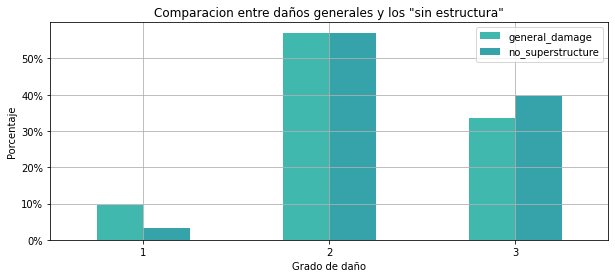

In [37]:
no_superstructure = superstructure_raw.loc[superstructure_raw['sum']==0, 'damage_grade'].value_counts(sort=False, normalize=True)
comparative_superstructure = pd.DataFrame({'general_damage': general_damage_normalize, 'no_superstructure':no_superstructure})
comparative_superstructure.plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.title('Comparacion entre daños generales y los "sin estructura"')
plt.show()

Son muy pocas las edificaciones "sin superestructura" que sufrieron daños leves. En comparación el resto de las edificaciones, las que no tenían superestructura eran mas propensas a sufrir daños más graves. 
Pero, ¿Que quiere decir que una edificación no tiene ningún tipo de superestructura? Vamos a asumir que en el caso de que no posea ningún tipo de superestructura, no se sabe exactamente que superestructura tiene y por lo tanto, son casos que no vamos a tener en cuenta para el análisis de materiales. 

In [38]:

superstructure = superstructure_raw.loc[superstructure_raw['sum'] > 0]

### Edificaciones con varias superestructuras
Hay edificaciones que fueron construidas hasta con 7 materiales distintos. Veamos si la variedad de materiales disminuye el impacto del terremoto. Para eso vamos a analizar aquellas edificaciones con 4 o más materiales.

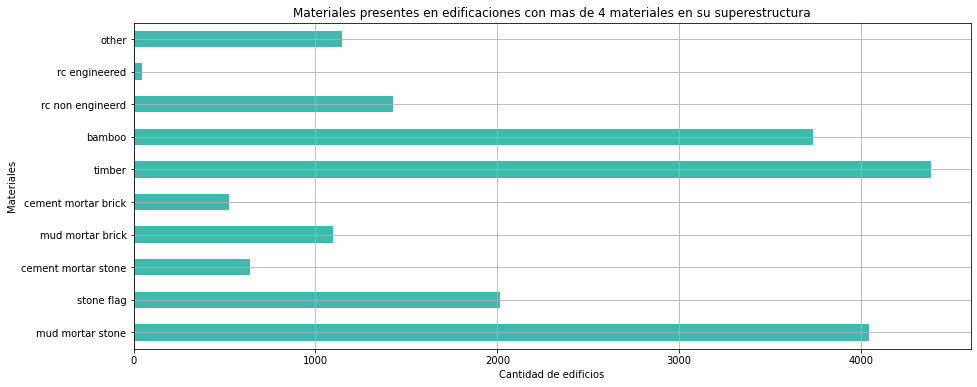

In [39]:
superstructure.loc[superstructure['sum']>3,:].sum().iloc[:-2].plot(kind='barh', figsize=(15,6))
plt.title('Materiales presentes en edificaciones con mas de 4 materiales en su superestructura')
plt.xlabel('Cantidad de edificios')
plt.ylabel('Materiales')
plt.yticks([0,1,2,3,4,5,6,7,8,9],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

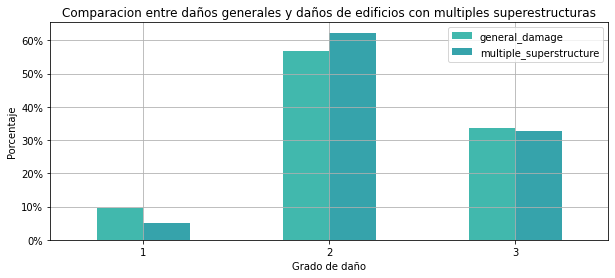

In [40]:
multiple_superstructure = superstructure.loc[superstructure['sum']>3,'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['multiple_superstructure'] = multiple_superstructure
comparative_superstructure[['general_damage','multiple_superstructure']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('Comparacion entre daños generales y daños de edificios con multiples superestructuras')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

Aquellas edificaciones con mútiples materiales de construcción tuvieron, en proporción, menos daños leves que el resto. Sin embargo, no se pueden sacar grandes conclusiones, probablemente lo mejor sea analizar cuál fue la respuesta de cada material o combinación de estos.

### Edificaciones con una superestructura única
El caso más frecuente es el de aquellas edificaciones que cuentan con una única superestructura. Como se ve en el siguiente gráfico, la mayoría de estas edificaciones están construidas con **barro - piedra**.

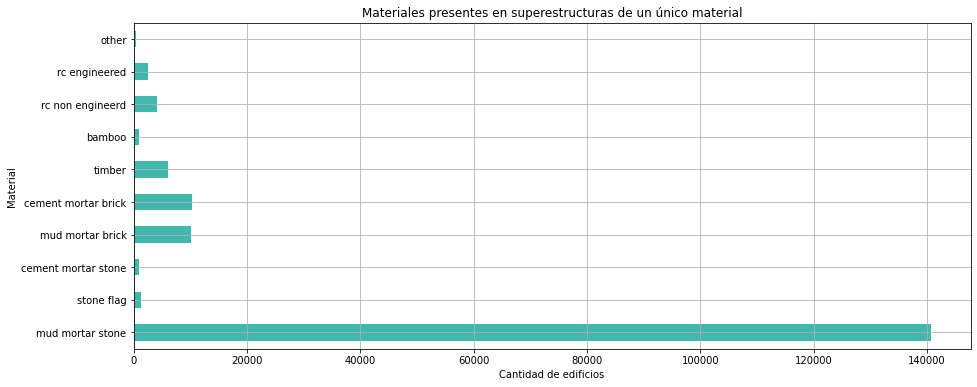

In [41]:
superstructure.loc[superstructure['sum']==1,:].sum().iloc[:-2].plot(kind='barh', figsize=(15,6))
plt.title('Materiales presentes en superestructuras de un único material')
plt.ylabel('Material')
plt.xlabel('Cantidad de edificios')
plt.yticks([0,1,2,3,4,5,6,7,8,9],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

Veamos como se distribuyen los materiales si dejamos de tener en cuenta a **barro - piedra**.

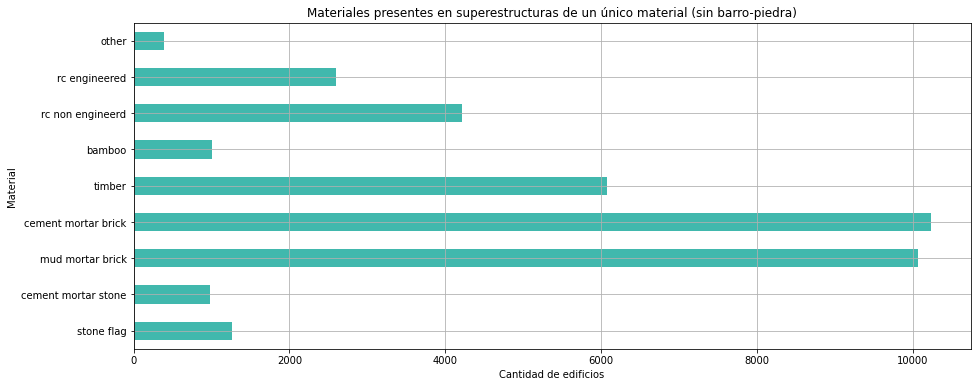

In [42]:
superstructure.loc[superstructure['sum']==1,:].sum().iloc[1:-2].plot(kind='barh', figsize=(15,6))
plt.title('Materiales presentes en superestructuras de un único material (sin barro-piedra)')
plt.ylabel('Material')
plt.xlabel('Cantidad de edificios')
plt.yticks([0,1,2,3,4,5,6,7,8],['stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

#### Proporción de edificaciones construidas con un determinado material para cada grado de daño

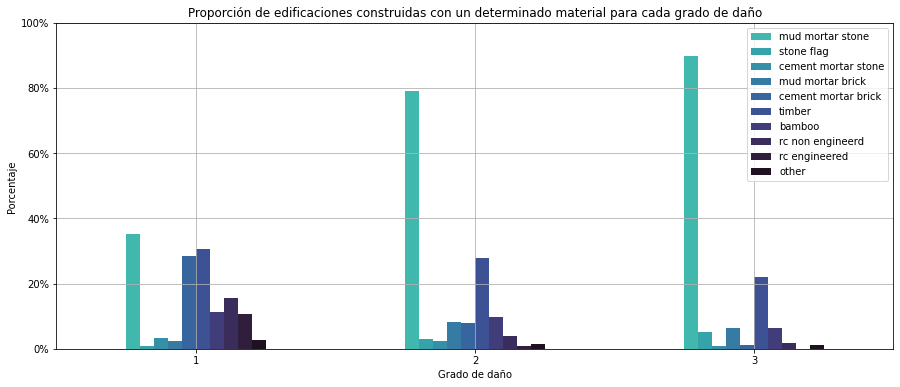

In [43]:
superstructure.iloc[:,:-1].groupby('damage_grade').agg(lambda x: x.sum() / x.count()).plot(kind='bar', figsize=(15,6), rot=0, ylim=(0,1), title='Proporción de edificaciones construidas con un determinado material para cada grado de daño').yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
ax = plt.gca()
ax.legend(['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()


Podemos ver que el material mas común es el barro, el cual no es  bueno contra terremotos (https://www.sciencedirect.com/topics/engineering/mud-mortar). Pero se puede observar que **entre los edificios con daños de grado 1 se usa una gran cantidad de cemento y madera** que se sabe que es mejor para mitigar daños provocados por sismos.

### Edificaciones construidas con barro - piedra
Empezamos analizando las edificaciones construidas con **barro - piedra** ya que es el material más recurrente.

In [44]:
superstructure['has_superstructure_mud_mortar_stone'].value_counts(normalize=True)

True     0.783674
False    0.216326
Name: has_superstructure_mud_mortar_stone, dtype: float64

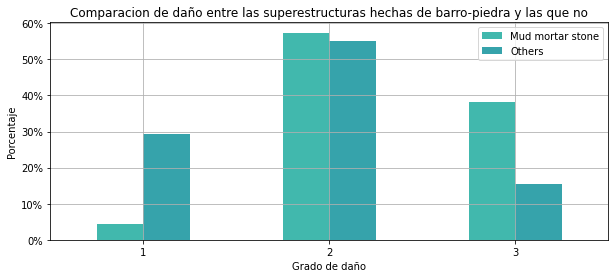

In [45]:
superstructure_mud_mortar_stone = superstructure.loc[superstructure['has_superstructure_mud_mortar_stone'] == True, 'damage_grade'].value_counts(normalize=True, sort=False)
no_superstructure_mud_mortar_stone = superstructure.loc[superstructure['has_superstructure_mud_mortar_stone'] == False, 'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['superstructure_mud_mortar_stone'] = superstructure_mud_mortar_stone
comparative_superstructure['no_superstructure_mud_mortar_stone'] = no_superstructure_mud_mortar_stone
comparative_superstructure[['superstructure_mud_mortar_stone', 'no_superstructure_mud_mortar_stone']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
ax.legend(['Mud mortar stone','Others'])
plt.title('Comparacion de daño entre las superestructuras hechas de barro-piedra y las que no')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

El 78% de las edificaciones fueron construidas con **barro - piedra**. En el gráfico se puede ver que aquellas construidas con estos materiales son mucho más propensas a sufrir daños graves que el resto. Esta es una variable muy importante a tener en cuenta porque la diferencia entre estos dos grupos es muy grande.

### Edificaciones construidas con cemento - ladrillo
En el [gráfico](#Proporción-de-edificaciones-construidas-con-un-determinado-material-para-cada-grado-de-daño) que indica la proporción de edificaciones construidas con un determinado material para cada grado de daño, hay un material en particular que llama mucho la atención: **cemento - ladrillo**.  

In [46]:
superstructure['has_superstructure_cement_mortar_brick'].value_counts(normalize=True)

False    0.922584
True     0.077416
Name: has_superstructure_cement_mortar_brick, dtype: float64

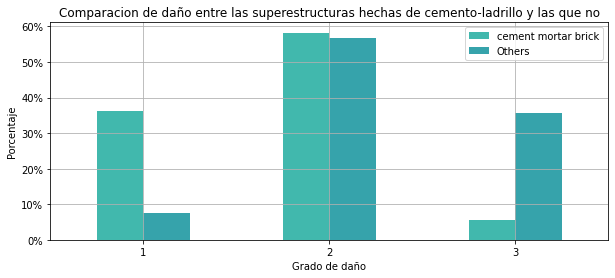

In [47]:
superstructure_cement_mortar_brick = superstructure.loc[superstructure['has_superstructure_cement_mortar_brick'] == True, 'damage_grade'].value_counts(normalize=True, sort=False)
no_superstructure_cement_mortar_brick = superstructure.loc[superstructure['has_superstructure_cement_mortar_brick'] == False, 'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['superstructure_cement_mortar_brick'] = superstructure_cement_mortar_brick
comparative_superstructure['no_superstructure_cement_mortar_brick'] = no_superstructure_cement_mortar_brick
comparative_superstructure[['superstructure_cement_mortar_brick', 'no_superstructure_cement_mortar_brick']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
ax.legend(['cement mortar brick','Others'])
plt.title('Comparacion de daño entre las superestructuras hechas de cemento-ladrillo y las que no')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

Solamente el 7,7% de las edificaciones fueron construidas con **cemento - ladrillo**. Estas edificaciones estaban mejor preparadas para enfrentar el terremoto, son muy pocas las que sufrieron daños graves.

### Edificaciones construidas con concreto reforzado no-diseñado

In [48]:
superstructure['has_superstructure_rc_non_engineered'].value_counts(normalize=True)

False    0.956195
True     0.043805
Name: has_superstructure_rc_non_engineered, dtype: float64

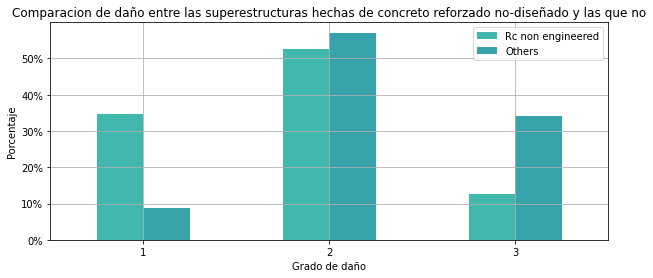

In [49]:
superstructure_rc_non_engineered = superstructure.loc[superstructure['has_superstructure_rc_non_engineered'] == True, 'damage_grade'].value_counts(normalize=True, sort=False)
no_superstructure_rc_non_engineered = superstructure.loc[superstructure['has_superstructure_rc_non_engineered'] == False, 'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['superstructure_rc_non_engineered'] = superstructure_rc_non_engineered
comparative_superstructure['no_superstructure_rc_non_engineered'] = no_superstructure_rc_non_engineered
comparative_superstructure[['superstructure_rc_non_engineered', 'no_superstructure_rc_non_engineered']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
ax.legend(['Rc non engineered','Others'])
plt.title('Comparacion de daño entre las superestructuras hechas de concreto reforzado no-diseñado y las que no')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

Menos del 5% de las edificaciones están construidas con **concreto reforzado no-diseñado**, sin embargo vemos que es muy resistente a los efectos del terremoto. Probablemente no sea un material muy usado por su precio.

### Edificaciones construidas con concreto reforzado diseñado

In [50]:
superstructure['has_superstructure_rc_engineered'].value_counts(normalize=True)

False    0.983688
True     0.016312
Name: has_superstructure_rc_engineered, dtype: float64

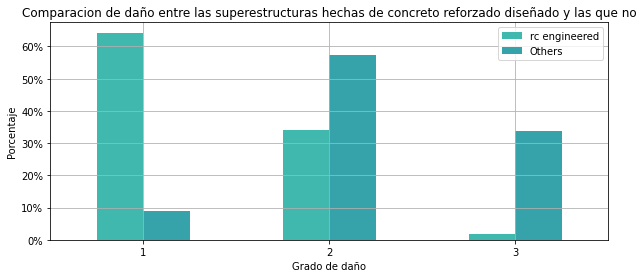

In [51]:
superstructure_rc_engineered = superstructure.loc[superstructure['has_superstructure_rc_engineered'] == True, 'damage_grade'].value_counts(normalize=True, sort=False)
no_superstructure_rc_engineered = superstructure.loc[superstructure['has_superstructure_rc_engineered'] == False, 'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['superstructure_rc_engineered'] = superstructure_rc_engineered
comparative_superstructure['no_superstructure_rc_engineered'] = no_superstructure_rc_engineered
comparative_superstructure[['superstructure_rc_engineered', 'no_superstructure_rc_engineered']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
ax.legend(['rc engineered','Others'])
plt.title('Comparacion de daño entre las superestructuras hechas de concreto reforzado diseñado y las que no')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

Aproximadamente el 1,6% de las edificaciones están construidas con **concreto reforzado diseñado**. Este material es más eficiente para resistir a los efectos del terremoto que los vistos anteriormente. Muy pocas edificaciones sufrieron daños grave y más de la mitad sufrieron daños leves.

### Edificaciones construidas con Timber
La madera **Timber** fue el segundo material de construccion más utilizado, por lo tanto es importante analizar cual fue su respuesta frente al terremoto.

In [52]:
superstructure['has_superstructure_timber'].value_counts(normalize=True)

False    0.737737
True     0.262263
Name: has_superstructure_timber, dtype: float64

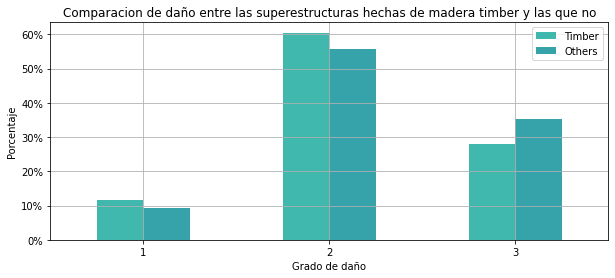

In [53]:
superstructure_timber = superstructure.loc[superstructure['has_superstructure_timber'] == True, 'damage_grade'].value_counts(normalize=True, sort=False)
no_superstructure_timber = superstructure.loc[superstructure['has_superstructure_timber'] == False, 'damage_grade'].value_counts(normalize=True, sort=False)
comparative_superstructure['superstructure_timber'] = superstructure_timber
comparative_superstructure['no_superstructure_timber'] = no_superstructure_timber
comparative_superstructure[['superstructure_timber', 'no_superstructure_timber']].plot(kind='bar', figsize=(10,4), rot=0, grid=True).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
ax.legend(['Timber','Others'])
plt.title('Comparacion de daño entre las superestructuras hechas de madera timber y las que no')
plt.ylabel('Porcentaje')
plt.xlabel('Grado de daño')
plt.show()

Aproximadamente el 26,2% de las edificaciones están construidas con **Timber**. Este material no parece ser determinante para reducir o no el impacto del terremoto. Tanto aquellas edificaciones que fueron contruidas con estos materiales como las que no tuvieron grados de daño similares.

### Análisis de las superestructuras en la regiones 17 y 26
Vimos anteriormente que considerando *geo_level_1_id*, tenemos dos casos extremos en cuanto al impacto que sufrieron debido al terremoto. Estos son los de la región 17 y la región 26. La región más afectada por el terremoto fue la 17. A continuación vemos si esta región se diferencia del resto en cuanto a sus materiales de construcción.

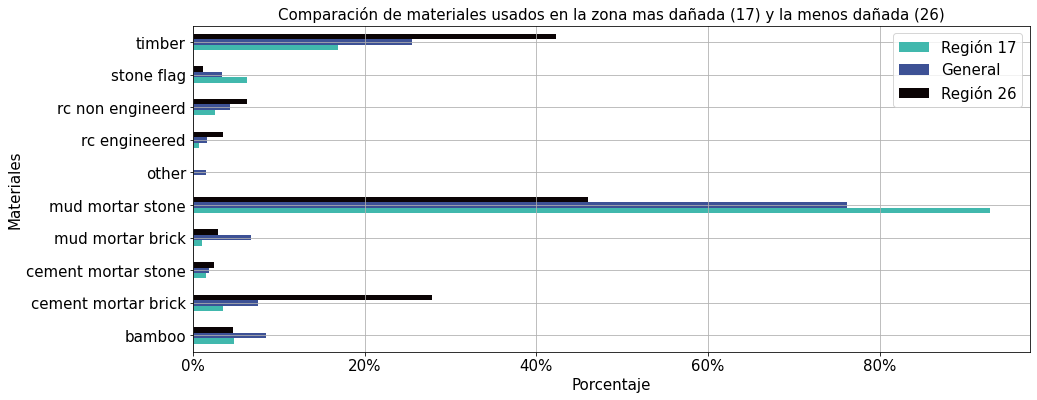

In [54]:
superstructure_geo_l1_17 = df.loc[(df['geo_level_1_id']==17), superstructure_columns + ['damage_grade']]
superstructure_geo_l1_26 = df.loc[(df['geo_level_1_id']==26), superstructure_columns + ['damage_grade']]


#estilo
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_horizontal)

comparative_superstructure_17_26 = pd.DataFrame(data={'Región 17':superstructure_geo_l1_17.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'General':superstructure_raw.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'Región 26':superstructure_geo_l1_26.agg(lambda x: x.sum()/x.count()).iloc[:-2]})
comparative_superstructure_17_26.plot(kind='barh', figsize=(15,6)).xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax = plt.gca()
plt.title('Comparación de materiales usados en la zona mas dañada (17) y la menos dañada (26)', fontsize=15)
plt.ylabel('Materiales', fontsize=15)
plt.xlabel('Porcentaje', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.yticks([4,8,2,3,1,9,0,7,6,5],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

La región 17 tiene una proporción de edificaciones construidas con **barro - piedra** mucho mayor a la general. Como vimos anteriormente, las edificaciones construidas con estos materiales no estaban preparadas para responder ante un terremoto y fueron las que sufrieron sus consecuencias más gravemente. También se observa que la proporción de edificaciones construidas con **cemento - ladrillo, concreto reforzado diseñado o concreto reforzado no diseñado** es mucho menor a la general. Estos materiales son los que mejor supieron mitigar los efectos del terremoto. La suma de estas dos cuestiones tiene como consecuencia que la región 17 sea la que sufrió el impacto del terremoto en mayor medida.

El análisis de la región 26 es inverso al de la región 17. Aquellos materiales que resultaron ser malos para resistir a un terremoto se encuentran en menor medida en la región 26 que en el resto de las regiones. Y aquellos materiales que son más eficientes para soportar un terremoto se encuentran en mayor medida en la zona 26 que en el resto de las regiones.

## ¿Cuál es el formato de construcción que mejor mitigó los efectos del terremoto?

In [55]:
construcciones_por_formato = df["plan_configuration"].value_counts()
construcciones_por_formato

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

Podemos ver que hay formatos de construcción de los cuáles tenemos muy poca información. Esto probablemente se deba a que son formatos poco comunes. Los analizaremos a todos y, de ser necesario, volveremos a analizar el formato de construcción teniendo en cuenta los formatos más comunes.

In [56]:
daño_por_formato = df[["building_id", "plan_configuration", "damage_grade"]].pivot_table(index="plan_configuration", columns="damage_grade", values="building_id",aggfunc="count")

In [57]:
total_dañados_por_formato = daño_por_formato[1]+daño_por_formato[2]+daño_por_formato[3]
daño_por_formato_porcentual = daño_por_formato.divide(total_dañados_por_formato, axis = 0).sort_values(by=3)

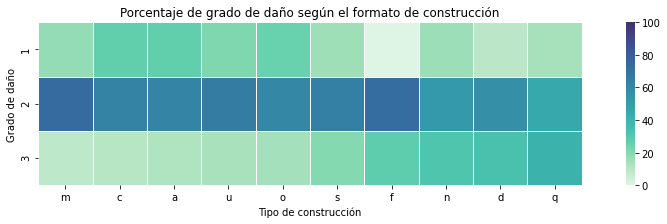

In [58]:
plt.figure(figsize=(16,3))
sns.heatmap(data=daño_por_formato_porcentual.T*100,cmap=cmap, vmin=0, vmax=100, linewidths=1, square=True)
plt.ylabel('Grado de daño')
plt.xlabel('Tipo de construcción')
plt.title('Porcentaje de grado de daño según el formato de construcción')
plt.show()

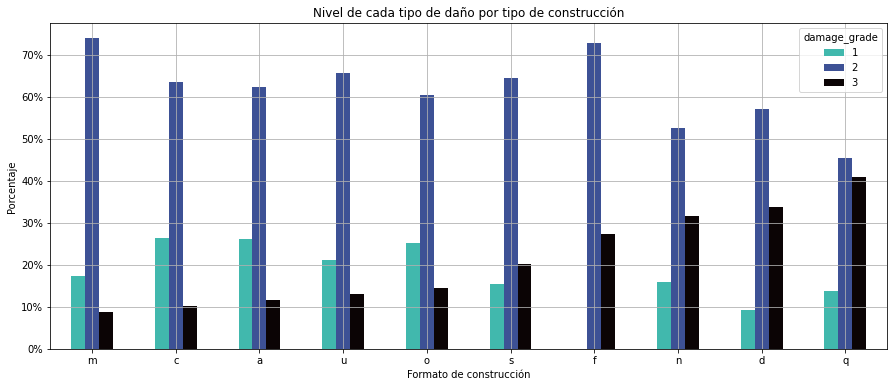

In [59]:
daño_por_formato_porcentual.plot(kind='bar', rot=0, title='Nivel de cada tipo de daño por tipo de construcción', figsize=(15,6)).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Porcentaje')
plt.xlabel('Formato de construcción')
plt.show()

Es dificil extraer información de estos gráficos. Más aún teniendo en cuenta que hay tipos de construcción con muy pocos datos. Procederemos a hacer el mismo análisis quitando los tipos de construcción con menos datos.

In [60]:
daño_por_formato_relevantes = daño_por_formato[total_dañados_por_formato>total_dañados_por_formato.quantile(0.5)]

In [61]:
daño_por_formato_porcentual_relevantes = daño_por_formato_relevantes.divide(total_dañados_por_formato, axis = 0).sort_values(by=3).dropna()

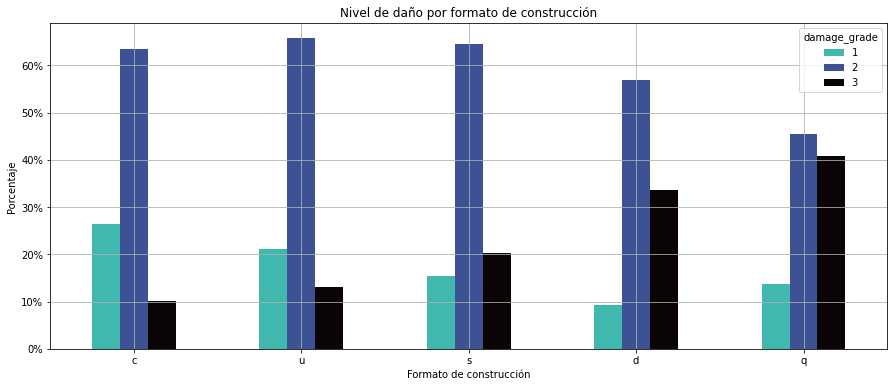

In [62]:
daño_por_formato_porcentual_relevantes.plot(kind='bar', rot=0, title='Nivel de daño por formato de construcción', figsize=(15,6)).yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Porcentaje')
plt.xlabel('Formato de construcción')
plt.show()

Aquí podemos observar que los tipos de construcción **c** y **u** fueron los que menos proporción de daños graves y los que mayor proporción de daños leves sufrieron (considerando solo los tipos de construcción más comunes).

También podemos observar como el tipo de construcción **q** sufrió considerablemente menos daños medios y más daños graves que el resto.

Una conclusión de este análisis es que el tipo de construcción común que mejor resistió el terremoto fue el tipo **c** y el que peor resistió fue el tipo **q**.

No hay que dejar de considerar sin embargo que la **gran mayoría** de construcciones son de tipo **d** tal vez por alguna razon socioeconómica.


## Análisis según la antigüedad de la construcción

In [63]:
construcciones_por_edad = df["age"].value_counts().sort_index()
minimos_casos = construcciones_por_edad.sum()/(construcciones_por_edad.count())

In [64]:
daño_por_antiguedad = df[["building_id", "age", "damage_grade"]].pivot_table(index="age", columns="damage_grade", values="building_id",aggfunc="count").fillna(0)

In [65]:
total_dañados_por_antiguedad = daño_por_antiguedad[1]+daño_por_antiguedad[2]+daño_por_antiguedad[3]
daño_por_antiguedad_relevantes = daño_por_antiguedad[total_dañados_por_antiguedad > minimos_casos]
daño_por_antiguedad_porcentual_relevantes = daño_por_antiguedad_relevantes.divide(total_dañados_por_antiguedad, axis = 0).dropna()
antiguedades_relevantes = daño_por_antiguedad_relevantes.index

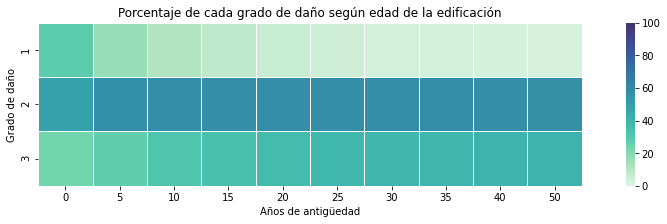

In [66]:
plt.figure(figsize=(16,3))
sns.heatmap(data=daño_por_antiguedad_porcentual_relevantes.T*100,cmap=cmap, vmin=0, vmax=100, linewidths=1, square=True)
plt.ylabel('Grado de daño')
plt.xlabel('Años de antigüedad')
plt.title('Porcentaje de cada grado de daño según edad de la edificación')
plt.show()

Este heatmap es difícil de visualizar por lo tanto no nos aporta mucha información. Probamos graficar los mismos datos en un gráfico de barras:

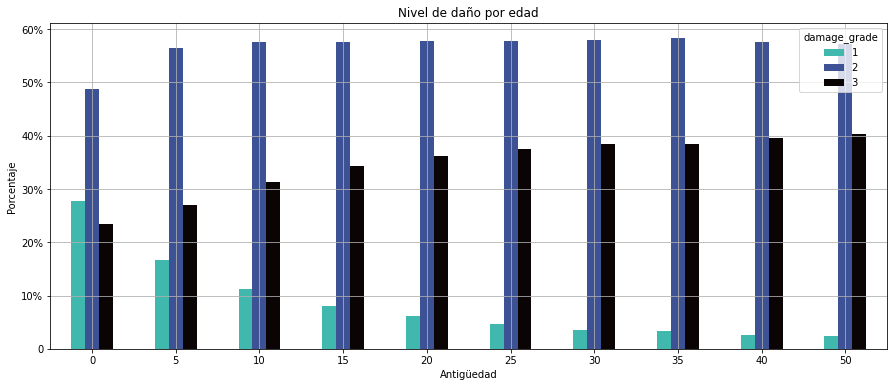

In [67]:
(daño_por_antiguedad_porcentual_relevantes*100).plot(kind='bar', rot=0, title='Nivel de daño por edad', figsize=(15,6))
plt.ylabel('Porcentaje')
plt.xlabel('Antigüedad')
plt.yticks([0,10,20,30,40,50,60],['0','10%','20%','30%','40%','50%','60%'])
plt.show()


Esta representación es bastante más útil. Se puede ver claramente una tendencia de los niveles de daño.

Cuanto más antigua la construcción, mayor el daño sufrido con un gran incremento en los daños serios.

También podemos ver como a menor antigüedad, los daños bajos son mucho más presentes desplazando principalmente a los daños graves y en menor medida los daños medianos.  

**¿Es esto determinante a la hora de predecir el grado de daño?**

#### ¿Existe una relación entre la antigüedad de una edificación y sus materiales de construcción?

In [68]:
materiales_por_antiguedad = df.set_index('age')[superstructure_columns]
materiales_por_antiguedad_relevantes = materiales_por_antiguedad.loc[antiguedades_relevantes]

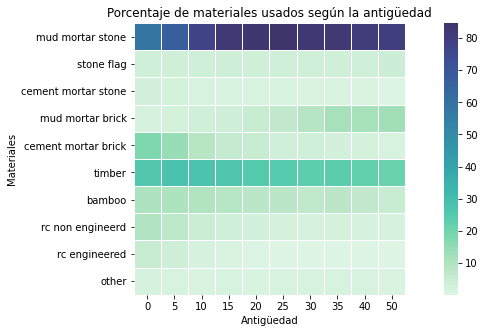

In [69]:
materiales_por_antiguedad_relevantes = materiales_por_antiguedad_relevantes.groupby('age').agg(lambda x: x.sum()/x.count())#.plot(kind='bar', figsize=(15,10), rot=0)
plt.figure(figsize=(14,5))
sns.heatmap(data=materiales_por_antiguedad_relevantes.T*100,cmap=cmap, linewidths=1, square=True)
plt.xticks(rotation=0)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.title('Porcentaje de materiales usados según la antigüedad')
plt.ylabel('Materiales')
plt.xlabel('Antigüedad')
plt.show()

Aquí vemos que hace 50 años el material mas usado con diferencia es piedra con barro. En los últimos 10 años empezo a decaer su uso pero aún así sigue siendo el mas utilizado con un gran margen sobre la madera (el segundo más popular). Es tan popular la piedra con barro que nos dificulta la visualización del resto de los materiales. Para analizarlos haremos el mismo gráfico quitando la piedra con barro.

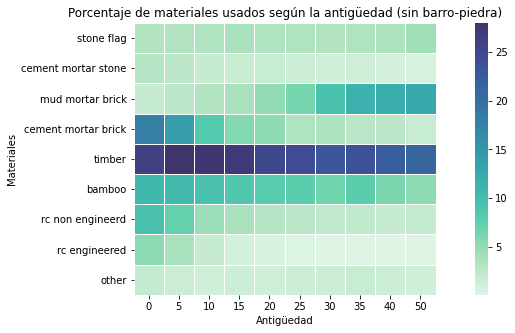

In [70]:
plt.figure(figsize=(14,5))
sns.heatmap(data=materiales_por_antiguedad_relevantes.drop('has_superstructure_mud_mortar_stone', axis=1).T*100,cmap=cmap, linewidths=1, square=True)
plt.xticks(rotation=0)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5],['stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.title('Porcentaje de materiales usados según la antigüedad (sin barro-piedra)')
plt.ylabel('Materiales')
plt.xlabel('Antigüedad')
plt.show()

Se puede apreciar como la madera ha sido constantemente el segundo material mas utilizado en los últimos 50 años llegando a su pico 5 años antes del terremoto. 
Este gráfico contiene solamente materiales minoritarios pero aún así la popularidad de la madera por sobre el resto sigue dificultando la visualización. Volveremos a graficarlo por última vez quitando la madera para poder visualizar mejor el resto de materiales.

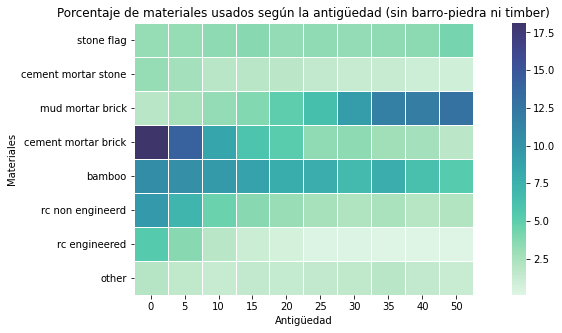

In [71]:
plt.figure(figsize=(14,5))
sns.heatmap(data=materiales_por_antiguedad_relevantes.drop(['has_superstructure_timber', 'has_superstructure_mud_mortar_stone'], axis=1).T*100,cmap=cmap, linewidths=1, square=True)
plt.xticks(rotation=0)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],['stone flag','cement mortar stone','mud mortar brick','cement mortar brick','bamboo','rc non engineerd','rc engineered','other'])
plt.title('Porcentaje de materiales usados según la antigüedad (sin barro-piedra ni timber)')
plt.ylabel('Materiales')
plt.xlabel('Antigüedad')
plt.show()

## Análisis por cantidad de pisos 
¿Existe una relación entre la cantidad de pisos que tiene un edificio y el daño que recibió?

In [72]:
cantidad_de_pisos_count=df['count_floors_pre_eq'].value_counts(sort=False)
cantidad_de_pisos_count

1     40441
2    156623
3     55617
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count_floors_pre_eq, dtype: int64

Hay solamente una edificación de 8 pisos y una de 9 pisos, por lo tanto para el siguiente análisis estas edificaciones no serán tenidas en cuenta.

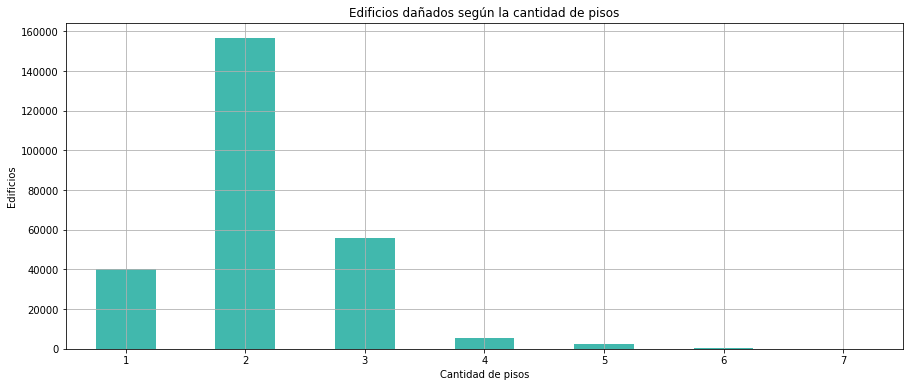

In [73]:
#estilo
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_cycler[200::-20])

cantidad_de_pisos_count.drop(labels=[8,9], inplace=True, errors='ignore')
cantidad_de_pisos_count.plot(kind='bar', rot=0,figsize=(15,6))
plt.title('Edificios dañados según la cantidad de pisos')
plt.ylabel('Edificios')
plt.xlabel('Cantidad de pisos')
plt.show()

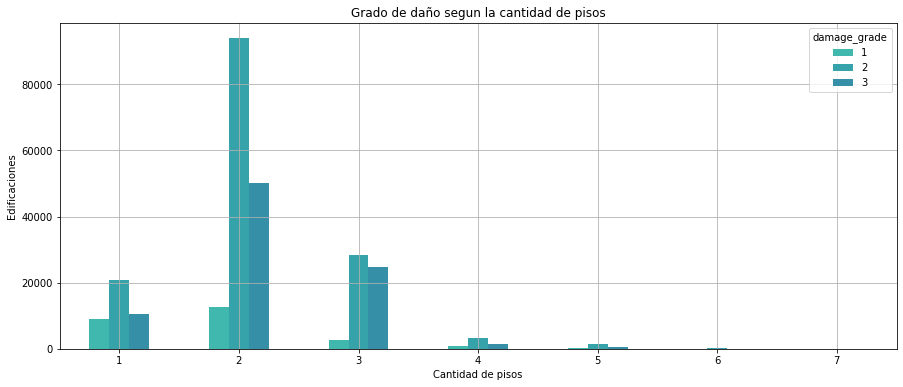

In [74]:
daño_por_cantidad_de_pisos = df.loc[df['count_floors_pre_eq']<8 ,['count_floors_pre_eq', 'damage_grade']].value_counts().to_frame().rename(columns={0:'value_counts'}).pivot_table(index='count_floors_pre_eq', columns='damage_grade', values='value_counts')
daño_por_cantidad_de_pisos.plot(kind='bar', figsize=(15,6), rot=0)
plt.title('Grado de daño segun la cantidad de pisos')
plt.ylabel('Edificaciones')
plt.xlabel('Cantidad de pisos')
plt.show()

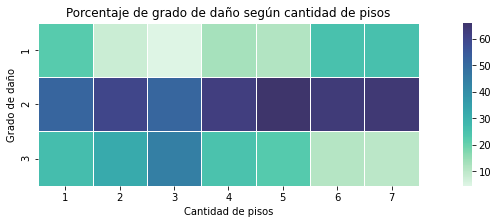

In [75]:
daño_por_cantidad_de_pisos_sum = daño_por_cantidad_de_pisos.sum(axis=1)
daño_por_cantidad_de_pisos_relativo = daño_por_cantidad_de_pisos.agg(lambda x: x / daño_por_cantidad_de_pisos_sum)
plt.figure(figsize=(16,3))
sns.heatmap(data=daño_por_cantidad_de_pisos_relativo.T*100, cmap=cmap, linewidths=1, square=True)
plt.title('Porcentaje de grado de daño según cantidad de pisos')
plt.ylabel('Grado de daño')
plt.xlabel('Cantidad de pisos')
plt.show()

Vemos que para edificaciones de pocos pisos la proporción de éstas con daños graves es mayor que la de daños leves. Pero a medida que la cantidad de pisos aumenta esto se invierte. Probablemente se deba a que para la construcción de las edificaciones de muchos pisos se haya invertido más dinero, y por lo tanto tenga mejores materiales que para las de menos pisos.

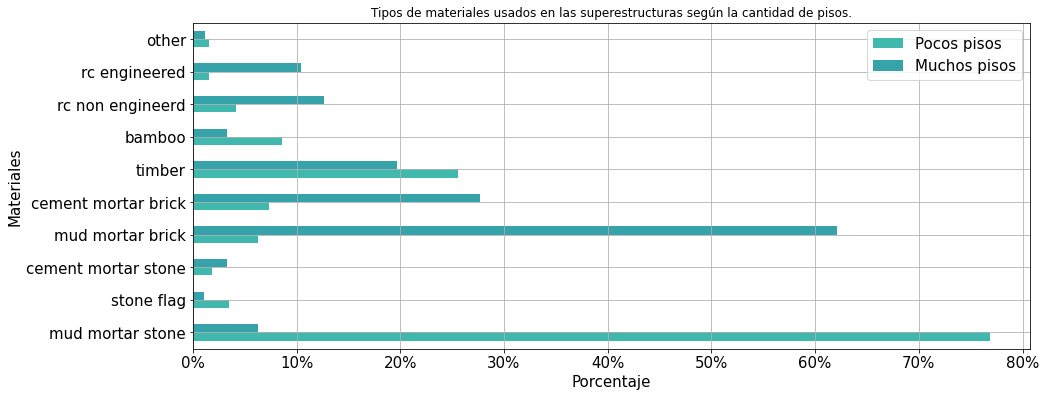

In [76]:
pocos_pisos=df.loc[df['count_floors_pre_eq'] < 5, superstructure_columns].agg(lambda x: x.sum()/x.count())
muchos_pisos=df.loc[df['count_floors_pre_eq'] >= 5, superstructure_columns].agg(lambda x: x.sum()/x.count())
materiales_por_cantidad_pisos = pd.DataFrame(data={'Pocos pisos':pocos_pisos, 'Muchos pisos':muchos_pisos})
materiales_por_cantidad_pisos.plot(kind='barh', figsize=(15,6)).xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#estilo
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_horizontal)

plt.title('Tipos de materiales usados en las superestructuras según la cantidad de pisos.')
plt.xlabel('Porcentaje', fontsize=15)
plt.ylabel('Materiales', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.yticks([0,1,2,3,4,5,6,7,8,9],['mud mortar stone','stone flag','cement mortar stone','mud mortar brick','cement mortar brick','timber','bamboo','rc non engineerd','rc engineered','other'])
plt.show()

Lo que suponíamos coincide con lo que muestra el gráfico, las edificaciones de 6 o más pisos usan materiales de construcción más eficientes para resistir el impacto de un terremoto según lo analizado en el apartado [Análisis según las condiciones y los materiales de construcción](#Analisis-según-las-condiciones-y-los-materiales-de-construcción).

### ¿Cuál es el promedio de edades en cada region de geo_level_1?
#### ¿Coincide con el grado de daño que recibieron? ¿Es mas determinante que el tipo de material?

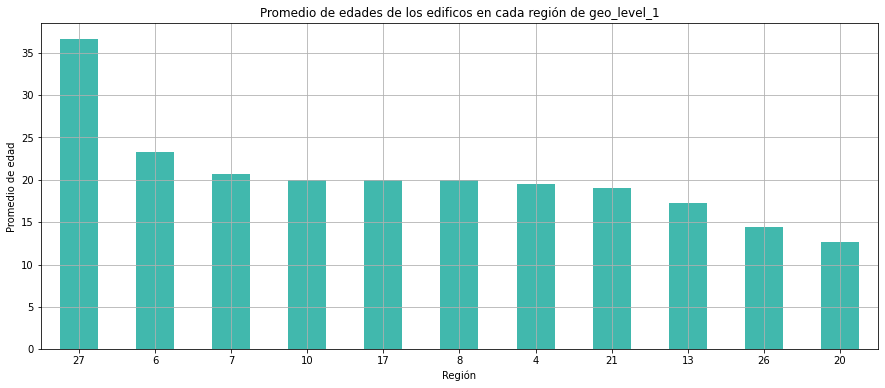

In [77]:
zonas_geo1 = df[['geo_level_1_id','age']]
zonas_geo1 = zonas_geo1.loc[zonas_geo1['age']<=200]
zonas_geo1=zonas_geo1.groupby('geo_level_1_id').agg({'age':['mean','count']})

zonas_geo1_relevantes = zonas_geo1[zonas_geo1[('age','count')]>zonas_geo1[('age','count')].mean()].sort_values(('age','mean'),ascending=False)
zonas_geo1_relevantes.drop(('age','count'),axis=1).plot(kind='bar',figsize=(15,6)).get_legend().remove()
plt.title('Promedio de edades de los edificos en cada región de geo_level_1')
plt.ylabel('Promedio de edad')
plt.xticks(rotation=0)
plt.xlabel('Región')
plt.show()

Recordemos [este gráfico](#another_cell) en el cual podemos ver la proporcion de cada tipo de daño en las regiones relevantes.

Quedandonos solamente con las regiones con mas edificios reportados.  
A simple vista vemos que la region 26 (la menos dañada) tiene un promedio de edad menor. ¿Esto significa que hay una correlacion directa entre el promedio de edad por región y el grado de daño? Si miramos las 6 regiones con mayor promedio de edad, son de las zonas con mayor grado de daño, pero la zona 27 **no es la que mayor daño tuvo aunque su promedio de edad es mucho mas alto que el resto.**  
Esto quiere decir que si bien el promedio de edad nos puede dar una idea del grado de daño que sufrió esa región, **no es determinante.**

Pero entonces... ¿qué es lo determinante?  
Comparemos las 6 regiones con mayor promedio de edad, en [este gráfico](#another_cell) vemos que leves diferencias de daños hubo, ¿será que los materiales de sus superestructuras nos dicen algo?

Miremos las regiones 8,10 y 17. Sabemos que si bien sus promedios de edades rondan el mismo valor, la zona 10 tiene *levemente menores daños que las otras.* Analizando sus superestructuras:

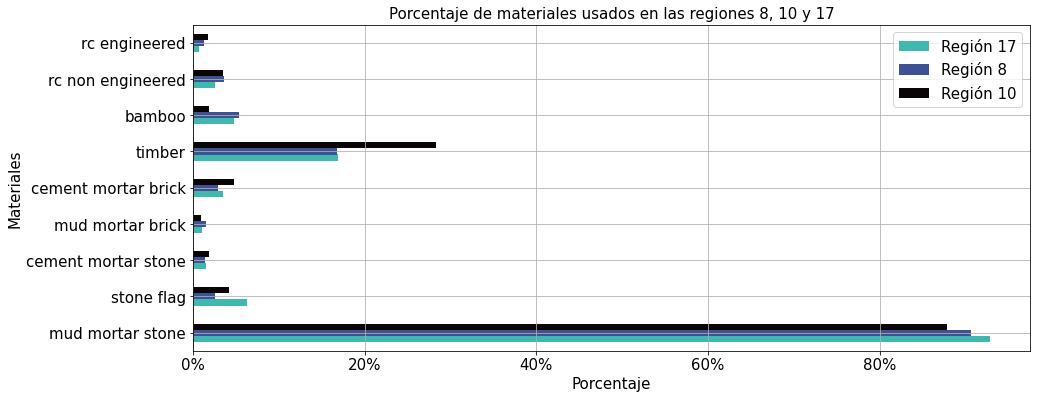

In [78]:
superstructure_geo_l1_17 = df.loc[(df['geo_level_1_id']==17), superstructure_columns + ['damage_grade']]
superstructure_geo_l1_8 = df.loc[(df['geo_level_1_id']==8), superstructure_columns + ['damage_grade']]
superstructure_geo_l1_10 = df.loc[(df['geo_level_1_id']==10), superstructure_columns + ['damage_grade']]

#estilo
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_horizontal)

comparative_superstructure_17_26 = pd.DataFrame(data={'Región 17':superstructure_geo_l1_17.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'Región 8':superstructure_geo_l1_8.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'Región 10':superstructure_geo_l1_10.agg(lambda x: x.sum()/x.count()).iloc[:-2]})
comparative_superstructure_17_26.index = ['mud mortar stone', 'stone flag',
       'cement mortar stone',
       'mud mortar brick',
       'cement mortar brick', 'timber',
       'bamboo', 'rc non engineered',
       'rc engineered']
comparative_superstructure_17_26.plot(kind='barh', figsize=(15,6)).xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Materiales', fontsize=15)
plt.xlabel('Porcentaje', fontsize=15)
plt.title('Porcentaje de materiales usados en las regiones 8, 10 y 17', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Pareciera ser que esa muy leve mejora al mitigar los daños en la region 10 se dio sobretodo a que habia mas edificaciones con una superestructura de madera (timber) que se sabe que es un poco mas resistente a terremotos.

Las otras 3 zonas con mayor promedio de edad son las regiones 6,7 y 27. Las cuales tambien tuvieron un daño importante. Veamos sus materiales:

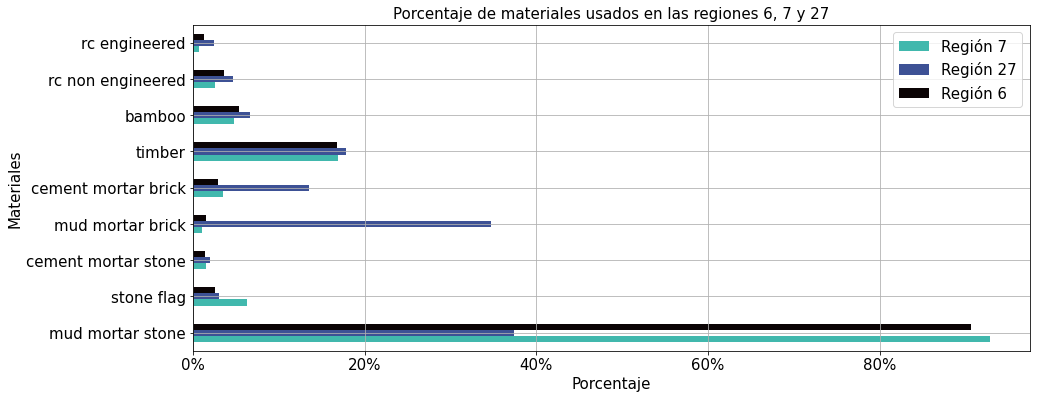

In [79]:
superstructure_geo_l1_7 = df.loc[(df['geo_level_1_id']==7), superstructure_columns + ['damage_grade']]
superstructure_geo_l1_6 = df.loc[(df['geo_level_1_id']==6), superstructure_columns + ['damage_grade']]
superstructure_geo_l1_27 = df.loc[(df['geo_level_1_id']==27), superstructure_columns + ['damage_grade']]



comparative_superstructure_17_26 = pd.DataFrame(data={'Región 7':superstructure_geo_l1_17.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'Región 27':superstructure_geo_l1_27.agg(lambda x: x.sum()/x.count()).iloc[:-2],
                                                      'Región 6':superstructure_geo_l1_8.agg(lambda x: x.sum()/x.count()).iloc[:-2]})
comparative_superstructure_17_26.index = ['mud mortar stone', 'stone flag',
       'cement mortar stone',
       'mud mortar brick',
       'cement mortar brick', 'timber',
       'bamboo', 'rc non engineered',
       'rc engineered']
comparative_superstructure_17_26.plot(kind='barh', figsize=(15,6)).xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Materiales', fontsize=15)
plt.xlabel('Porcentaje',fontsize=15)
plt.title('Porcentaje de materiales usados en las regiones 6, 7 y 27', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Si bien parece que la zona 27 uso menos piedras de barro, tambien usaron mas ladrillos de barro. Es un material que sigue siendo poco eficaz contra terremotos.

# Conclusiones

Podemos concluir que el material del cual estan hechas las edificaciones es mas importante que la antigüedad a la hora de preveer el daño que recibirán. Si bien hay una correlacion muy mínima entre antigüedad y materiales, esta **no es suficiente para poder afirmar que haya una causalidad entre ambas.** Tambien podemos llegar a la conclusión de que la causa principal por la cual hubo el mayor daño recibido por este terremoto fue **que la mayoria de las edificaciones damnificadas estaban hechas con barro** y esa no es la mejor opción ante un sismo.

Si tuvieramos que predecir el grado de daño de una edificacion, probablemente miraríamos primero con qué material fueron construidas sus superestructuras, ya que pareciera ser lo mas importanten a la hora de mitigar el daño del sismo.

# RandomForest
#### Híper parámetros
* n_estimators: cantidad de árboles a construir
* max_depth: máxima profundidad de cada árbol
* min_samples_split: la cantidad mínima de datos requeridos para splitear un nodo interno
* min_samples_leaf: cantidad mínima de datos requeridos para ser una hoja
* max_features: la cantidad de features a considerar cuando se busca el mejor split

In [80]:
df_forest = df.drop(["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type", "position", "other_floor_type", "plan_configuration", "legal_ownership_status"], axis=1)
df_forest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   building_id                             260601 non-null  int64
 1   geo_level_1_id                          260601 non-null  int8 
 2   geo_level_2_id                          260601 non-null  int16
 3   geo_level_3_id                          260601 non-null  int16
 4   count_floors_pre_eq                     260601 non-null  int8 
 5   age                                     260601 non-null  int16
 6   area_percentage                         260601 non-null  int8 
 7   height_percentage                       260601 non-null  int8 
 8   has_superstructure_adobe_mud            260601 non-null  bool 
 9   has_superstructure_mud_mortar_stone     260601 non-null  bool 
 10  has_superstructure_stone_flag           260601 non-null  bool 
 11  

In [81]:
df_forest.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,True,True,...,False,False,False,False,False,False,False,False,False,3
1,28830,8,900,2812,2,10,8,7,False,True,...,False,False,False,False,False,False,False,False,False,2
2,94947,21,363,8973,2,10,5,5,False,True,...,False,False,False,False,False,False,False,False,False,3
3,590882,22,418,10694,2,10,6,5,False,True,...,False,False,False,False,False,False,False,False,False,2
4,201944,11,131,1488,3,30,8,9,True,False,...,False,False,False,False,False,False,False,False,False,3


In [82]:
X,y = df_forest.iloc[:,:-1], df_forest.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### híper parámetros por defecto

In [83]:
#rf_model = RandomForestRegressor(random_state=1)
#rf_model.fit(X_train, y_train)
#preads = rf_model.predict(X_test)
#rmse = np.sqrt(mean_squared_error(y_test, preads))
#print("RMSE: %f" % (rmse))

#### Importancia de las features

In [84]:
# Gini importance
#rf_model.feature_importances_

In [86]:
#plt.bar(X_train.columns, rf_model.feature_importances_)
#plt.xlabel("Features")
#plt.ylabel("Importancia")
#plt.title("Importancia Features con RF")
#plt.xticks(rotation=90)
#plt.show

#### usando solo 5 árboles

In [87]:
rf_model = RandomForestRegressor(random_state=1, n_estimators=5)
rf_model.fit(X_train, y_train)
preads = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preads))
print("RMSE: %f" % (rmse))

RMSE: 0.500903


#### usando solo 5 árboles y 7 features

In [88]:
rf_model = RandomForestRegressor(random_state=1, n_estimators=5, max_features=7)
rf_model.fit(X_train, y_train)
preads = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preads))
print("RMSE: %f" % (rmse))

RMSE: 0.507827


In [105]:
tree0 = rf_model.estimators_[0]

DecisionTreeRegressor(max_features=7, random_state=1791095845)

In [112]:
#fig = plt.figure(figsize=(25,20))
#arbol = tree.plot_tree(tree0, 
#                   feature_names=X_test.columns,  
#                   filled=True)

#resultado horrible en una foto, tarda mucho

# 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮
![title](decistion_tree.png)
# 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮